In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.cluster.hierarchy import dendrogram, linkage as scipy_linkage, fcluster
from scipy.spatial.distance import cdist

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN as DBSCAN_sk
from sklearn.metrics import silhouette_score
from sklearn.mixture import GaussianMixture
from sklearn.metrics.pairwise import euclidean_distances

np.random.seed(42)
plt.style.use('dark_background')

import warnings
warnings.filterwarnings('ignore')

# utils

### HC

In [2]:
def hc(distances):
    """
    Выполняет иерархическую кластеризацию на основе матрицы расстояний.

    Параметры:
    distances (np.ndarray): Матрица расстояний между объектами.

    Возвращает:
    tuple: Словарь парных расстояний и словарь мощностей кластеров.
    """

    N = len(distances)
    powers = list(np.ones(N, dtype=np.int64))  # инициализируем мощности кластеров

    cluster_ids = list(range(N))  # инициализируем идентификаторы кластеров
    pairwise_distances = {}  # словарь для хранения парных расстояний
    all_clusters_power = {c_id: p for (c_id, p) in zip(cluster_ids, powers)}  # словарь для хранения мощностей всех кластеров

    while N > 2:
        idx_ = np.argmin(distances)  # находим индекс минимального расстояния
        idx_i, idx_j = np.unravel_index(idx_, distances.shape)  # разворачиваем индекс в координаты

        i_p = powers[idx_i]  # мощность первого кластера
        j_p = powers[idx_j]  # мощность второго кластера

        d = distances[idx_i, idx_j]  # минимальное расстояние между кластерами
        pairwise_distances[(cluster_ids[idx_i], cluster_ids[idx_j])] = d  # сохраняем парное расстояние

        max_cluster_id = max(cluster_ids)  # находим максимальный идентификатор кластера
        for idx in sorted([idx_i, idx_j], reverse=True):
            del powers[idx]  # удаляем мощности объединенных кластеров
            del cluster_ids[idx]  # удаляем идентификаторы объединенных кластеров

        alpha_u = (np.array(powers) + i_p) / (np.array(powers) + i_p + j_p)  # коэффициент для первого кластера
        alpha_v = (np.array(powers) + j_p) / (np.array(powers) + i_p + j_p)  # коэффициент для второго кластера
        beta = -np.array(powers) / (np.array(powers) + i_p + j_p)  # коэффициент для корректировки расстояний

        distances = np.delete(distances, [idx_i, idx_j], axis=0)  # удаляем строки объединенных кластеров
        distance_ = np.sqrt(
            alpha_u * np.square(distances[:, idx_i]) +
            alpha_v * np.square(distances[:, idx_j]) +
            beta * (d**2)
        )  # вычисляем новые расстояния

        distances = np.delete(distances, [idx_i, idx_j], axis=1)  # удаляем столбцы объединенных кластеров

        distances_ = np.zeros((N-1, N-1))  # создаем новую матрицу расстояний
        distances_[:-1, :-1] = distances  # копируем старые расстояния
        distances_[-1, -1] = np.inf  # устанавливаем бесконечное расстояние для нового кластера
        distances_[-1, :-1] = distance_.T  # копируем новые расстояния для нового кластера
        distances_[:-1, -1] = distance_  # копируем новые расстояния для нового кластера

        distances = distances_  # обновляем матрицу расстояний

        powers.append(i_p + j_p)  # добавляем мощность нового кластера
        cluster_ids.append(max_cluster_id + 1)  # добавляем идентификатор нового кластера
        all_clusters_power[max_cluster_id + 1] = i_p + j_p  # обновляем мощность нового кластера
        N -= 1  # уменьшаем количество кластеров

    distances = np.min(distances).reshape((1, 1))  # находим минимальное расстояние для последних двух кластеров
    pairwise_distances[(cluster_ids[0], cluster_ids[1])] = distances[0, 0]  # сохраняем парное расстояние для последних двух кластеров
    powers = [sum(powers)]  # обновляем мощности кластеров
    cluster_ids = [max(cluster_ids) + 1]  # обновляем идентификаторы кластеров

    return pairwise_distances, all_clusters_power

In [3]:
def calculate_metrics_hc(data, linkage_matrix, num_clusters):
    """
    Вычисляет средние внутрикластерные и межкластерные расстояния.

    Параметры:
        data (numpy.ndarray): Данные, на основе которых выполнялась кластеризация.
        linkage_matrix (numpy.ndarray): Матрица linkage.
        num_clusters (int): Число кластеров.

    Возвращает:
        avg_intra_cluster_dist (float): Среднее внутрикластерное расстояние.
        avg_inter_cluster_dist (float): Среднее межкластерное расстояние.
    """

    # получаем метки кластеров для каждой точки данных
    cluster_labels = fcluster(linkage_matrix, num_clusters, criterion="maxclust")

    centroids = []
    # вычисляем центроиды для каждого кластера
    for cluster in range(1, num_clusters + 1):
        cluster_points = data[cluster_labels == cluster]  # точки, принадлежащие текущему кластеру
        centroid = cluster_points.mean(axis=0)  # центроид текущего кластера
        centroids.append(centroid)
    centroids = np.array(centroids)  # преобразуем список центроидов в массив

    intra_distances = []
    # вычисляем внутрикластерные расстояния
    for cluster in range(1, num_clusters + 1):
        cluster_points = data[cluster_labels == cluster]  # точки, принадлежащие текущему кластеру
        centroid = centroids[cluster - 1]  # центроид текущего кластера
        distances = np.linalg.norm(cluster_points - centroid, axis=1)  # расстояния от точек до центроида
        intra_distances.extend(distances)  # добавляем расстояния в список
    avg_intra_cluster_dist = np.mean(intra_distances)  # среднее внутрикластерное расстояние

    # вычисляем межкластерные расстояния
    inter_distances = cdist(centroids, centroids, metric="euclidean")
    np.fill_diagonal(inter_distances, np.nan)  # заменяем диагональные элементы на NaN
    avg_inter_cluster_dist = np.nanmean(inter_distances)  # среднее межкластерное расстояние, игнорируя NaN

    return avg_intra_cluster_dist, avg_inter_cluster_dist

### EM

In [4]:
def gaussian_pdf(x, mean, cov):
    """
    Вычисляет значение функции плотности вероятности многомерного нормального распределения.

    Параметры:
        x (numpy.ndarray): Вектор значений.
        mean (numpy.ndarray): Вектор средних значений.
        cov (numpy.ndarray): Ковариационная матрица.

    Возвращает:
        float: Значение функции плотности вероятности.
    """

    d = len(mean)  # размерность пространства
    diff = x - mean  # разность между вектором значений и вектором средних значений
    cov_inv = np.linalg.inv(cov)  # обратная ковариационная матрица
    exponent = -0.5 * np.dot(np.dot(diff.T, cov_inv), diff)  # экспоненциальная часть формулы

    # вычисляем значение функции плотности вероятности
    return (1 / np.sqrt((2 * np.pi) ** d * np.linalg.det(cov))) * np.exp(exponent)

In [5]:
def em_algorithm(data, k, max_iters=100, tol=1e-6):
    """
    Выполняет алгоритм ожидания-максимизации (EM) для смеси гауссовых распределений.

    Параметры:
        data (numpy.ndarray): Матрица данных.
        k (int): Число компонентов смеси.
        max_iters (int): Максимальное число итераций. По умолчанию 100.
        tol (float): Толерантность для остановки алгоритма. По умолчанию 1e-6.

    Возвращает:
        means (numpy.ndarray): Векторы средних значений компонентов.
        covariances (list): Ковариационные матрицы компонентов.
        weights (numpy.ndarray): Веса компонентов.
        responsibilities (numpy.ndarray): Матрица ответственностей.
        log_likelihoods (list): Список значений логарифмической правдоподобности.
    """

    n_samples, _ = data.shape  # количество образцов и размерность данных

    # инициализация средних значений, ковариационных матриц и весов
    means = data[np.random.choice(n_samples, k, replace=False)]
    covariances = [np.cov(data.T) for _ in range(k)]
    weights = np.ones(k) / k

    log_likelihoods = []  # список для хранения значений логарифмической правдоподобности

    for _ in range(max_iters):
        responsibilities = np.zeros((n_samples, k))

        # шаг ожидания: вычисляем ответственности
        for j in range(k):
            for i in range(n_samples):
                responsibilities[i, j] = weights[j] * gaussian_pdf(
                    data[i], means[j], covariances[j]
                )

        responsibilities_sum = responsibilities.sum(axis=1, keepdims=True)
        responsibilities /= responsibilities_sum  # нормализуем

        cluster_weights = responsibilities.sum(axis=0)  # сумма по кластерам
        new_means = np.dot(responsibilities.T, data) / cluster_weights[:, None]  # новые средние значения

        new_covariances = []
        for j in range(k):
            diff = data - new_means[j]  # разность между данными и новыми средними значениями
            cov = np.dot(responsibilities[:, j] * diff.T, diff) / cluster_weights[j]  # новая ковариационная матрица
            new_covariances.append(cov)

        new_weights = cluster_weights / n_samples  # новые веса

        log_likelihood = np.sum(np.log(responsibilities_sum))  # логарифмическая правдоподобность
        log_likelihoods.append(log_likelihood)

        # проверяем условие остановки
        if len(log_likelihoods) > 1 and np.abs(log_likelihood - log_likelihoods[-2]) < tol:
            break

        # обновляем параметры
        means, covariances, weights = new_means, new_covariances, new_weights

    return means, covariances, weights, responsibilities, log_likelihoods

In [6]:
def compute_metrics_em(data, responsibilities):
    """
    Вычисляет средние внутрикластерные и межкластерные расстояния для результатов алгоритма EM.

    Параметры:
        data (numpy.ndarray): Матрица данных.
        responsibilities (numpy.ndarray): Матрица ответственностей.

    Возвращает:
        avg_intra_cluster_dist (float): Среднее внутрикластерное расстояние.
        avg_inter_cluster_dist (float): Среднее межкластерное расстояние.
    """

    _, n_clusters = responsibilities.shape  # количество кластеров
    centroids = np.dot(responsibilities.T, data) / responsibilities.sum(axis=0)[:, None]  # центроиды кластеров

    intra_distances = []
    # вычисляем внутрикластерные расстояния
    for i in range(n_clusters):
        cluster_points = data[np.argmax(responsibilities, axis=1) == i]  # точки, принадлежащие текущему кластеру
        if cluster_points.shape[0] > 0:
            centroid = centroids[i]  # центроид текущего кластера
            distances = np.linalg.norm(cluster_points - centroid, axis=1)  # расстояния от точек до центроида
            intra_distances.append(np.mean(distances))  # среднее расстояние внутри кластера

    inter_distances = []
    # вычисляем межкластерные расстояния
    for i in range(n_clusters):
        for j in range(i + 1, n_clusters):
            distance = np.linalg.norm(centroids[i] - centroids[j])  # расстояние между центроидами
            inter_distances.append(distance)  # добавляем расстояние в список

    return np.mean(intra_distances), np.mean(inter_distances)  # средние внутрикластерное и межкластерное расстояния

### dbscan

In [7]:
def dbscan(data, eps, min_samples):
    """
    Выполняет кластеризацию DBSCAN.

    Параметры:
        data (numpy.ndarray): Матрица данных.
        eps (float): Максимальное расстояние между двумя точками для того, чтобы они считались соседями.
        min_samples (int): Минимальное количество точек для формирования плотного кластера.

    Возвращает:
        labels (numpy.ndarray): Вектор меток кластеров.
    """

    n_samples = len(data)  # количество образцов
    labels = np.full(n_samples, -1)  # инициализация меток кластеров как -1 (шум)
    visited = np.zeros(n_samples, dtype=bool)  # массив посещенных точек
    cluster_id = 0  # начальный идентификатор кластера

    def region_query(point_idx):
        """
        Находит все точки в пределах eps от заданной точки.

        Параметры:
            point_idx (int): Индекс точки.

        Возвращает:
            neighbors (numpy.ndarray): Индексы соседних точек.
        """
        distances = euclidean_distances(data[point_idx].reshape(1, -1), data)  # вычисляем расстояния от точки до всех остальных
        neighbors = np.where(distances <= eps)[1]  # находим индексы точек в пределах eps
        return neighbors

    def expand_cluster(point_idx, neighbors, cluster_id):
        """
        Расширяет кластер, начиная с заданной точки.

        Параметры:
            point_idx (int): Индекс начальной точки.
            neighbors (numpy.ndarray): Индексы соседних точек.
            cluster_id (int): Идентификатор кластера.
        """
        labels[point_idx] = cluster_id  # присваиваем метку кластера начальной точке
        i = 0
        while i < len(neighbors):
            neighbor_idx = neighbors[i]
            if not visited[neighbor_idx]:
                visited[neighbor_idx] = True
                neighbor_neighbors = region_query(neighbor_idx)  # находим соседей соседа
                if len(neighbor_neighbors) >= min_samples:
                    neighbors = np.append(neighbors, neighbor_neighbors)  # добавляем соседей в список
            if labels[neighbor_idx] == -1:
                labels[neighbor_idx] = cluster_id  # присваиваем метку кластера соседу
            i += 1

    for point_idx in range(n_samples):
        if visited[point_idx]:
            continue

        visited[point_idx] = True
        neighbors = region_query(point_idx)

        if len(neighbors) < min_samples:
            labels[point_idx] = -1  # метка шума
        else:
            cluster_id += 1
            expand_cluster(point_idx, neighbors, cluster_id)

    return labels

In [8]:
def compute_metrics_dbscan(data, labels):
    """
    Вычисляет средние внутрикластерные и межкластерные расстояния для результатов алгоритма DBSCAN.

    Параметры:
        data (numpy.ndarray): Матрица данных.
        labels (numpy.ndarray): Вектор меток кластеров.

    Возвращает:
        avg_intra_cluster_dist (float): Среднее внутрикластерное расстояние.
        avg_inter_cluster_dist (float): Среднее межкластерное расстояние.
    """

    clusters = np.unique(labels)  # уникальные метки кластеров
    clusters = clusters[clusters != -1]  # исключаем метку шума (-1)

    intra_distances = []
    inter_distances = []

    # вычисляем внутрикластерные расстояния
    for cluster in clusters:
        cluster_points = data[labels == cluster]  # точки, принадлежащие текущему кластеру
        centroid = np.mean(cluster_points, axis=0)  # центроид текущего кластера
        distances = np.linalg.norm(cluster_points - centroid, axis=1)  # расстояния от точек до центроида
        intra_distances.append(np.mean(distances))  # среднее расстояние внутри кластера

    # вычисляем межкластерные расстояния
    for i, cluster1 in enumerate(clusters):
        for cluster2 in clusters[i+1:]:
            cluster1_points = data[labels == cluster1]  # точки, принадлежащие первому кластеру
            cluster2_points = data[labels == cluster2]  # точки, принадлежащие второму кластеру
            distances = np.linalg.norm(cluster1_points[:, None] - cluster2_points[None, :], axis=2)  # расстояния между точками двух кластеров
            inter_distances.append(np.min(distances))  # минимальное расстояние между кластерами

    return np.mean(intra_distances), np.mean(inter_distances)  # средние внутрикластерное и межкластерное расстояния

# Wine

In [9]:
wine_df = pd.read_csv('../wine-clustering.csv')
wine_df

,Alcohol,Malic_Acid,Ash,Ash_Alcanity,Magnesium,Total_Phenols,Flavanoids,Nonflavanoid_Phenols,Proanthocyanins,Color_Intensity,Hue,OD280,Proline
0,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735
...,...,...,...,...,...,...,...,...,...,...,...,...,...
173,13.71,5.65,2.45,20.5,95,1.68,0.61,0.52,1.06,7.70,0.64,1.74,740
174,13.40,3.91,2.48,23.0,102,1.80,0.75,0.43,1.41,7.30,0.70,1.56,750
175,13.27,4.28,2.26,20.0,120,1.59,0.69,0.43,1.35,10.20,0.59,1.56,835
176,13.17,2.59,2.37,20.0,120,1.65,0.68,0.53,1.46,9.30,0.60,1.62,840


## research

In [10]:
wine_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 178 entries, 0 to 177
Data columns (total 13 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Alcohol                178 non-null    float64
 1   Malic_Acid             178 non-null    float64
 2   Ash                    178 non-null    float64
 3   Ash_Alcanity           178 non-null    float64
 4   Magnesium              178 non-null    int64  
 5   Total_Phenols          178 non-null    float64
 6   Flavanoids             178 non-null    float64
 7   Nonflavanoid_Phenols   178 non-null    float64
 8   Proanthocyanins        178 non-null    float64
 9   Color_Intensity        178 non-null    float64
 10  Hue                    178 non-null    float64
 11  OD280                  178 non-null    float64
 12  Proline                178 non-null    int64  
dtypes: float64(11), int64(2)
memory usage: 18.2 KB


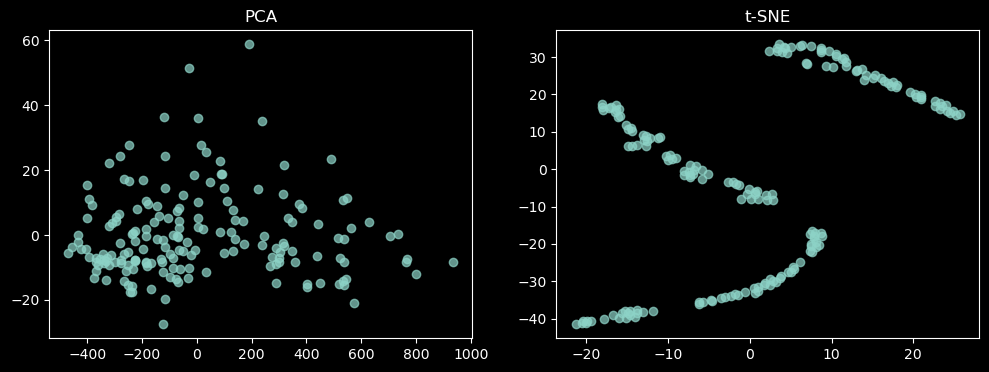

In [11]:
pca = PCA(n_components=2)
pca_data = pca.fit_transform(wine_df)

tsne = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=10)
tsne_data = tsne.fit_transform(wine_df)

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.scatter(pca_data[:, 0], pca_data[:, 1], alpha=0.7)
plt.title('PCA')

plt.subplot(1, 2, 2)
plt.scatter(tsne_data[:, 0], tsne_data[:, 1], alpha=0.7)
plt.title('t-SNE')

plt.savefig('../assets/wine_pca_tsne.png')
plt.show()

In [12]:
wine_sdf = StandardScaler().fit_transform(wine_df.to_numpy())

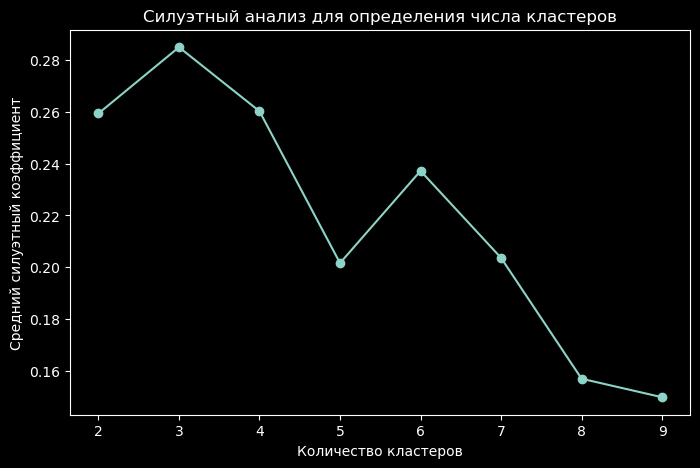

In [13]:
silhouette_scores = []
k_values = range(2, 10)
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    cluster_labels = kmeans.fit_predict(wine_sdf)
    silhouette_avg = silhouette_score(wine_sdf, cluster_labels)
    silhouette_scores.append(silhouette_avg)

plt.figure(figsize=(8, 5))
plt.plot(k_values, silhouette_scores, marker='o')
plt.title("Силуэтный анализ для определения числа кластеров")
plt.xlabel("Количество кластеров")
plt.ylabel("Средний силуэтный коэффициент")
plt.savefig('../assets/wine_analysis.png')
plt.show()

исходя из анализа всех 3х графиков, можно сделать вывод о том, что оптимальное число кластеров - 3

## HC

In [14]:
%%time 
distance_matrix = cdist(wine_sdf, wine_sdf)
np.fill_diagonal(distance_matrix, np.inf)
pairwise_distances, all_clusters_power = hc(distance_matrix)
linkage_matrix = np.array([]).reshape((0, 4))
for (cluster1, cluster2), distance in pairwise_distances.items():
    row = np.array(
        [
            cluster1,
            cluster2,
            distance,
            all_clusters_power[cluster1]
            + all_clusters_power[cluster2],
        ]
    )
    linkage_matrix = np.vstack([linkage_matrix, row])

linkage_matrix.shape

CPU times: user 23.2 ms, sys: 75 µs, total: 23.2 ms
Wall time: 21.7 ms


(177, 4)

CPU times: user 1.45 ms, sys: 824 µs, total: 2.27 ms
Wall time: 1.51 ms


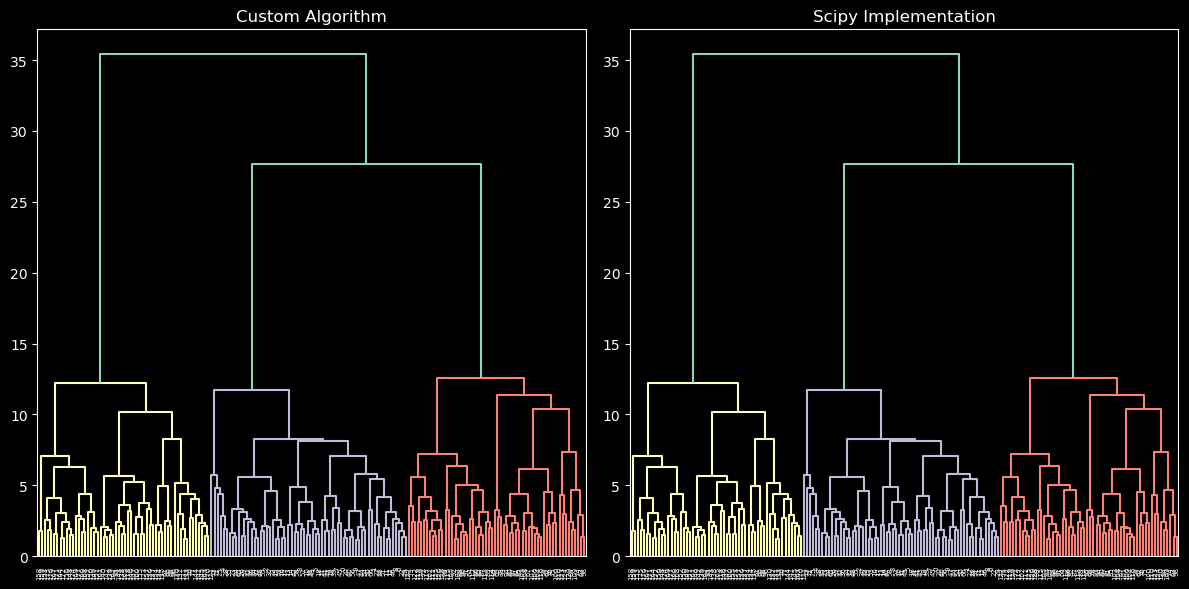

In [15]:
%time Z = scipy_linkage(wine_sdf, method="ward")

fig, axes = plt.subplots(1, 2, figsize=(12, 6))
dendrogram(linkage_matrix, ax=axes[0])
axes[0].set_title("Custom Algorithm")

dendrogram(Z, ax=axes[1])
axes[1].set_title("Scipy Implementation")

plt.tight_layout()
plt.savefig('../assets/wine_hc_compare.png')
plt.show()

In [16]:
num_clusters = 3
avg_intra, avg_inter = calculate_metrics_hc(wine_sdf, linkage_matrix, num_clusters)

print(f"Среднее внутрикластерное расстояние: {avg_intra}")
print(f"Среднее межкластерное расстояние: {avg_inter}")

Среднее внутрикластерное расстояние: 2.5546093591164794
Среднее межкластерное расстояние: 4.0879590553601455


## EM

CPU times: user 3.6 s, sys: 17 s, total: 20.6 s
Wall time: 1.87 s


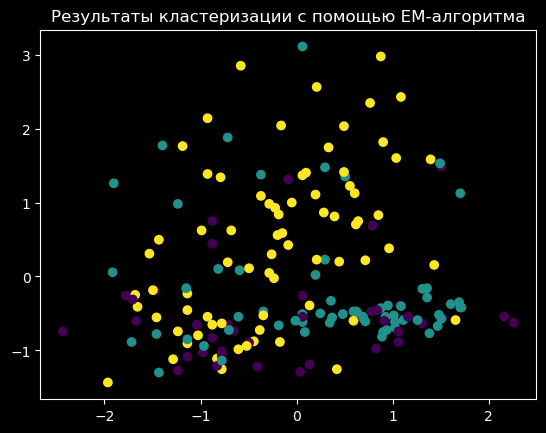

In [17]:
%time means, covariances, weights, responsibilities, log_likelihoods = em_algorithm(wine_sdf, k=3)

plt.scatter(
    wine_sdf[:, 0],
    wine_sdf[:, 1],
    c=np.argmax(responsibilities, axis=1),
    cmap="viridis",
)
plt.title('Результаты кластеризации с помощью EM-алгоритма')
plt.savefig('../assets/wine_own_em.png')
plt.show()

CPU times: user 48.7 ms, sys: 0 ns, total: 48.7 ms
Wall time: 22.7 ms
CPU times: user 222 µs, sys: 0 ns, total: 222 µs
Wall time: 226 µs


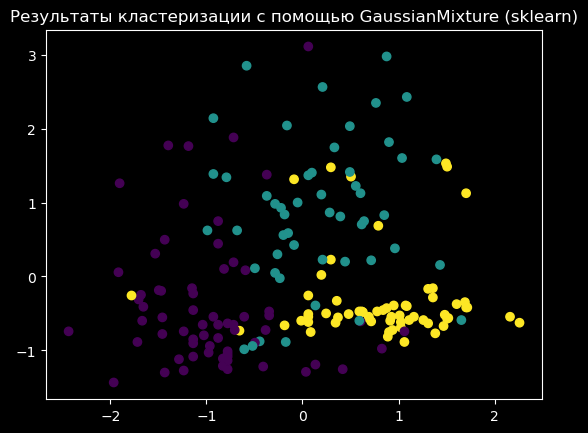

In [18]:
gmm = GaussianMixture(n_components=3, covariance_type='full')
%time gmm.fit(wine_sdf)
%time gmm_labels = gmm.predict(wine_sdf)

plt.scatter(wine_sdf[:, 0], wine_sdf[:, 1], c=gmm_labels, cmap="viridis")
plt.title('Результаты кластеризации с помощью GaussianMixture (sklearn)')
plt.savefig('../assets/wine_bem.png')
plt.show()

In [19]:
avg_intra, avg_inter = compute_metrics_em(wine_sdf, responsibilities)
print(f"Среднее внутрикластерное расстояние (EM-алгоритм): {avg_intra}")
print(f"Среднее межкластерное расстояние (EM-алгоритм): {avg_inter}")

Среднее внутрикластерное расстояние (EM-алгоритм): 2.9667553927217907
Среднее межкластерное расстояние (EM-алгоритм): 2.98406898241416


## DBSCAN

In [20]:
eps_values = np.arange(1, 5, 0.1)
min_samples_values = range(3, 11)

for eps in eps_values:
    for min_samples in min_samples_values:
        labels = dbscan(wine_sdf, eps, min_samples)
        avg_intra, avg_inter = compute_metrics_dbscan(wine_sdf, labels)
        if avg_inter > 1e-6: print(f"eps={eps} min_samples={min_samples}: Среднее внутрикластерное расстояние: {avg_intra}, Среднее межкластерное расстояние: {avg_inter}")

eps=1.4000000000000004 min_samples=3: Среднее внутрикластерное расстояние: 0.8742901263022639, Среднее межкластерное расстояние: 4.212218195991538
eps=1.5000000000000004 min_samples=3: Среднее внутрикластерное расстояние: 0.9668008846364484, Среднее межкластерное расстояние: 3.6968795327375035
eps=1.5000000000000004 min_samples=4: Среднее внутрикластерное расстояние: 1.0569950102826389, Среднее межкластерное расстояние: 2.5389708126254695
eps=1.6000000000000005 min_samples=3: Среднее внутрикластерное расстояние: 1.0992930788932562, Среднее межкластерное расстояние: 3.6391315151080947
eps=1.6000000000000005 min_samples=4: Среднее внутрикластерное расстояние: 1.056544745413327, Среднее межкластерное расстояние: 3.516418216269056
eps=1.6000000000000005 min_samples=5: Среднее внутрикластерное расстояние: 1.0973585031644135, Среднее межкластерное расстояние: 4.2425004012974314
eps=1.7000000000000006 min_samples=3: Среднее внутрикластерное расстояние: 1.2106474897868558, Среднее межкластерно

CPU times: user 20.4 ms, sys: 6.33 ms, total: 26.7 ms
Wall time: 20.6 ms


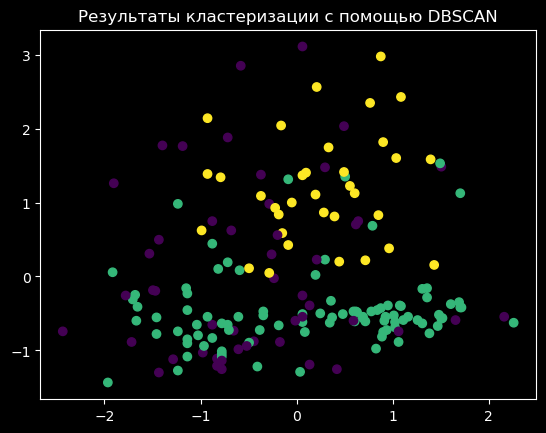

In [21]:
eps = 2.4
min_samples = 10

%time labels = dbscan(wine_sdf, eps, min_samples)

plt.scatter(wine_sdf[:, 0], wine_sdf[:, 1], c=labels, cmap="viridis")
plt.title("Результаты кластеризации с помощью DBSCAN")
plt.savefig('../assets/wine_own_dbscan.png')
plt.show()

CPU times: user 5 µs, sys: 5 µs, total: 10 µs
Wall time: 12.6 µs
CPU times: user 1.76 ms, sys: 1.77 ms, total: 3.52 ms
Wall time: 2.03 ms


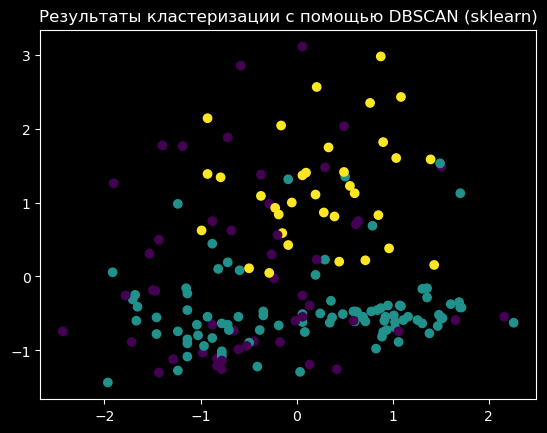

In [22]:
%time db = DBSCAN_sk(eps=2.4, min_samples=10)
%time labels_sk = db.fit_predict(wine_sdf)

plt.scatter(wine_sdf[:, 0], wine_sdf[:, 1], c=labels_sk, cmap="viridis")
plt.title("Результаты кластеризации с помощью DBSCAN (sklearn)")
plt.savefig('../assets/wine_bdbscan.png')
plt.show()

In [23]:
avg_intra, avg_inter = compute_metrics_dbscan(wine_sdf, labels)
print(f"Среднее внутрикластерное расстояние (DBSCAN): {avg_intra}")
print(f"Среднее межкластерное расстояние (DBSCAN): {avg_inter}")

Среднее внутрикластерное расстояние (DBSCAN): 2.4552258311351554
Среднее межкластерное расстояние (DBSCAN): 2.426608601084693


# Countries

## research

In [24]:
country_df = pd.read_csv('../Country-data.csv')
country_df.drop(columns=['country'], inplace=True)
country_df

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,90.2,10.0,7.58,44.9,1610,9.44,56.2,5.82,553
1,16.6,28.0,6.55,48.6,9930,4.49,76.3,1.65,4090
2,27.3,38.4,4.17,31.4,12900,16.10,76.5,2.89,4460
3,119.0,62.3,2.85,42.9,5900,22.40,60.1,6.16,3530
4,10.3,45.5,6.03,58.9,19100,1.44,76.8,2.13,12200
...,...,...,...,...,...,...,...,...,...
162,29.2,46.6,5.25,52.7,2950,2.62,63.0,3.50,2970
163,17.1,28.5,4.91,17.6,16500,45.90,75.4,2.47,13500
164,23.3,72.0,6.84,80.2,4490,12.10,73.1,1.95,1310
165,56.3,30.0,5.18,34.4,4480,23.60,67.5,4.67,1310


In [25]:
country_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 167 entries, 0 to 166
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   child_mort  167 non-null    float64
 1   exports     167 non-null    float64
 2   health      167 non-null    float64
 3   imports     167 non-null    float64
 4   income      167 non-null    int64  
 5   inflation   167 non-null    float64
 6   life_expec  167 non-null    float64
 7   total_fer   167 non-null    float64
 8   gdpp        167 non-null    int64  
dtypes: float64(7), int64(2)
memory usage: 11.9 KB


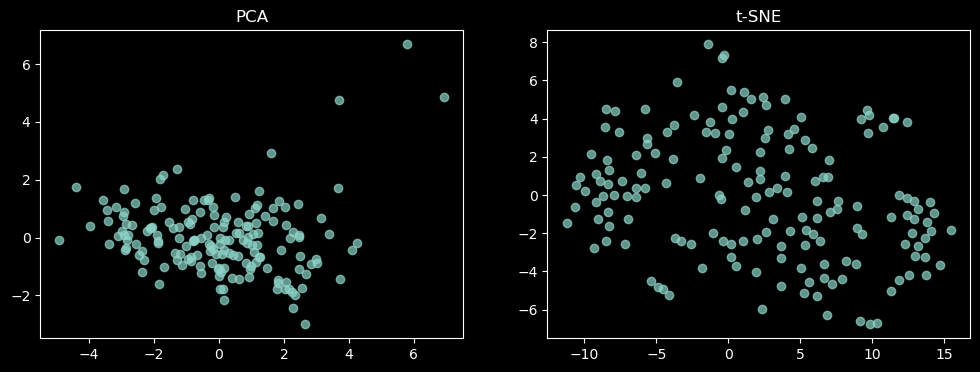

In [26]:
scaler = StandardScaler()
scaled_counties_data = scaler.fit_transform(country_df)

pca = PCA(n_components=2)
pca_data = pca.fit_transform(scaled_counties_data)

tsne = TSNE(n_components=2, random_state=42)
tsne_data = tsne.fit_transform(scaled_counties_data)

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.scatter(pca_data[:, 0], pca_data[:, 1], alpha=0.7)
plt.title('PCA')

plt.subplot(1, 2, 2)
plt.scatter(tsne_data[:, 0], tsne_data[:, 1], alpha=0.7)
plt.title('t-SNE')

plt.savefig('../assets/country_pca_tsne.png')

plt.show()

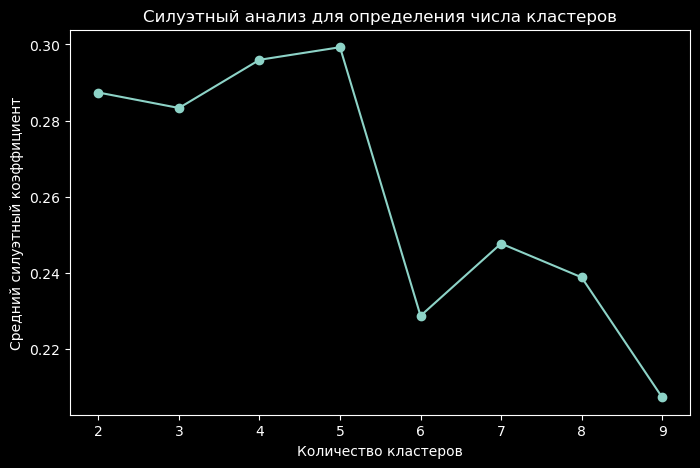

In [27]:
silhouette_scores = []
k_values = range(2, 10)
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    cluster_labels = kmeans.fit_predict(scaled_counties_data)
    silhouette_avg = silhouette_score(scaled_counties_data, cluster_labels)
    silhouette_scores.append(silhouette_avg)

plt.figure(figsize=(8, 5))
plt.plot(k_values, silhouette_scores, marker='o')
plt.title("Силуэтный анализ для определения числа кластеров")
plt.xlabel("Количество кластеров")
plt.ylabel("Средний силуэтный коэффициент")
plt.savefig('../assets/country_analysis.png')
plt.show()

исходя из анализа всех 3х графиков, можно сделать вывод о том, что оптимальное число кластеров - 5

In [28]:
country_sdf = StandardScaler().fit_transform(country_df.to_numpy())

## HC 

In [29]:
%%time
distance_matrix = cdist(country_sdf, country_sdf)
np.fill_diagonal(distance_matrix, np.inf)
pairwise_distances, all_clusters_power = hc(distance_matrix)
linkage_matrix = np.array([]).reshape((0, 4))
for (cluster1, cluster2), distance in pairwise_distances.items():
    row = np.array(
        [
            cluster1,
            cluster2,
            distance,
            all_clusters_power[cluster1]
            + all_clusters_power[cluster2],
        ]
    )
    linkage_matrix = np.vstack([linkage_matrix, row])

linkage_matrix.shape

CPU times: user 18.3 ms, sys: 220 µs, total: 18.5 ms
Wall time: 18 ms


(166, 4)

CPU times: user 1.01 ms, sys: 8 µs, total: 1.02 ms
Wall time: 865 µs


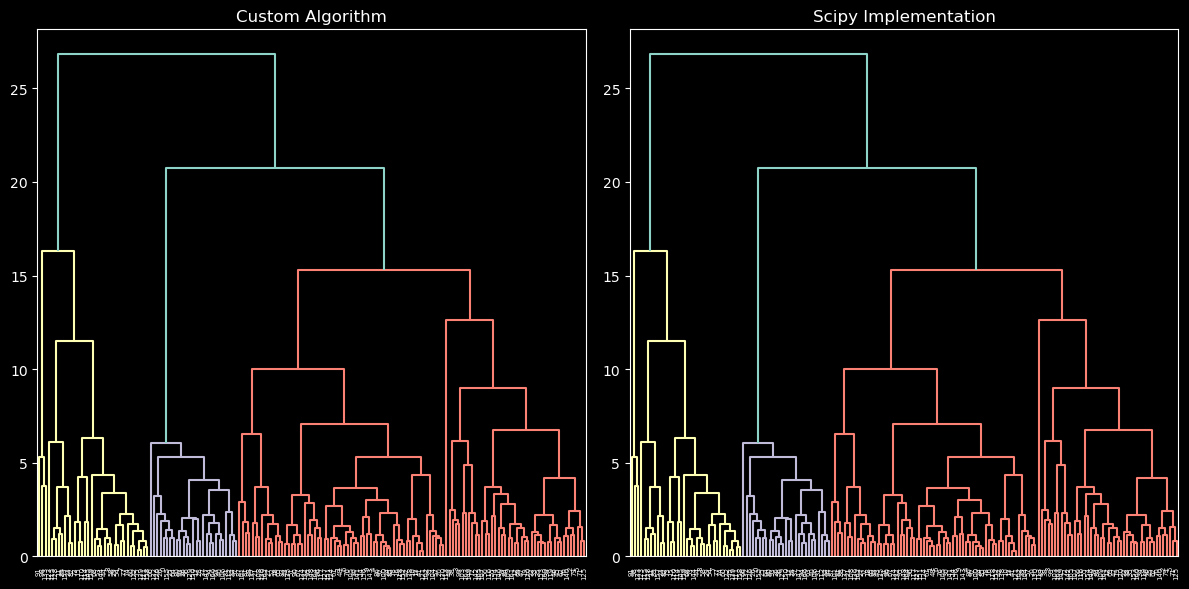

In [30]:
%time Z = scipy_linkage(country_sdf, method="ward")

fig, axes = plt.subplots(1, 2, figsize=(12, 6))
dendrogram(linkage_matrix, ax=axes[0])
axes[0].set_title("Custom Algorithm")

dendrogram(Z, ax=axes[1])
axes[1].set_title("Scipy Implementation")

plt.tight_layout()
plt.savefig('../assets/country_hc_compare.png')
plt.show()

In [31]:
num_clusters = 4
avg_intra, avg_inter = calculate_metrics_hc(country_sdf, linkage_matrix, num_clusters)

print(f"Среднее внутрикластерное расстояние: {avg_intra}")
print(f"Среднее межкластерное расстояние: {avg_inter}")

Среднее внутрикластерное расстояние: 1.9288700687162161
Среднее межкластерное расстояние: 6.077681664230604


## EM

CPU times: user 1.57 s, sys: 5.35 s, total: 6.91 s
Wall time: 780 ms


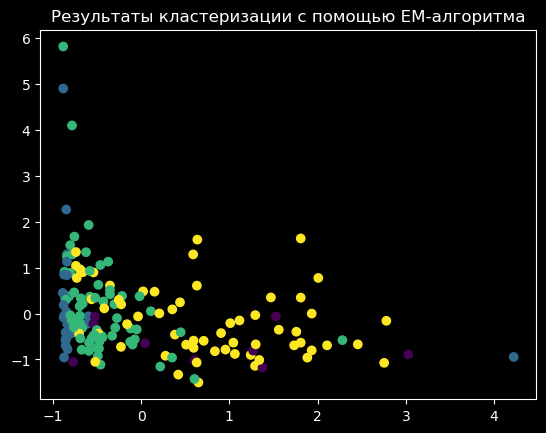

In [32]:
%time means, covariances, weights, responsibilities, log_likelihoods = em_algorithm(country_sdf, k=4)

plt.scatter(
    country_sdf[:, 0],
    country_sdf[:, 1],
    c=np.argmax(responsibilities, axis=1),
    cmap="viridis",
)
plt.title("Результаты кластеризации с помощью EM-алгоритма")
plt.savefig('../assets/country_own_em.png')
plt.show()

CPU times: user 130 ms, sys: 386 µs, total: 130 ms
Wall time: 15.9 ms
CPU times: user 6.97 ms, sys: 0 ns, total: 6.97 ms
Wall time: 451 µs


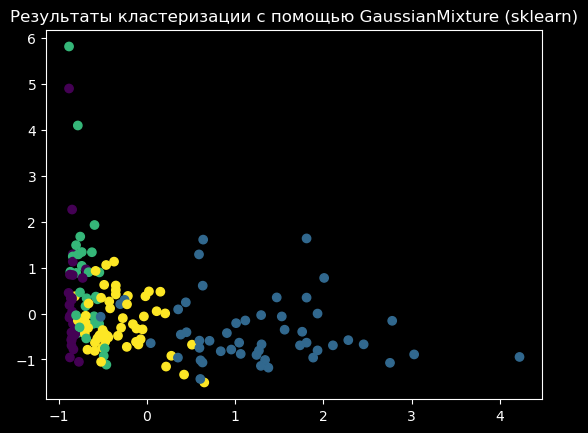

In [33]:
gmm = GaussianMixture(n_components=4, covariance_type="full")
%time gmm.fit(country_sdf)
%time gmm_labels = gmm.predict(country_sdf)

plt.scatter(country_sdf[:, 0], country_sdf[:, 1], c=gmm_labels, cmap="viridis")
plt.title("Результаты кластеризации с помощью GaussianMixture (sklearn)")
plt.savefig('../assets/country_bem.png')
plt.show()

In [34]:
avg_intra, avg_inter = compute_metrics_em(country_sdf, responsibilities)
print(f"Среднее внутрикластерное расстояние (EM-алгоритм): {avg_intra}")
print(f"Среднее межкластерное расстояние (EM-алгоритм): {avg_inter}")

Среднее внутрикластерное расстояние (EM-алгоритм): 2.1475074992165384
Среднее межкластерное расстояние (EM-алгоритм): 3.0658617274445703


## DBSCAN

In [35]:
eps_values = np.arange(1, 5, 0.1)
min_samples_values = range(3, 11)

for eps in eps_values:
    for min_samples in min_samples_values:
        labels = dbscan(country_sdf, eps, min_samples)
        avg_intra, avg_inter = compute_metrics_dbscan(country_sdf, labels)
        if avg_inter > 1e-6:
            print(
                f"eps={eps} min_samples={min_samples}: Среднее внутрикластерное расстояние: {avg_intra}, Среднее межкластерное расстояние: {avg_inter}"
            )

eps=1.0 min_samples=3: Среднее внутрикластерное расстояние: 0.8366597086214907, Среднее межкластерное расстояние: 2.5529389308567683
eps=1.0 min_samples=4: Среднее внутрикластерное расстояние: 0.8891479723313878, Среднее межкластерное расстояние: 2.489974788309432
eps=1.0 min_samples=5: Среднее внутрикластерное расстояние: 0.9564362577198318, Среднее межкластерное расстояние: 2.724340732308525
eps=1.0 min_samples=6: Среднее внутрикластерное расстояние: 0.9706780754213324, Среднее межкластерное расстояние: 1.4240314579999405
eps=1.0 min_samples=7: Среднее внутрикластерное расстояние: 0.9268734811964624, Среднее межкластерное расстояние: 1.438860447818247
eps=1.0 min_samples=8: Среднее внутрикластерное расстояние: 0.8212445317812983, Среднее межкластерное расстояние: 1.556243422937552
eps=1.0 min_samples=9: Среднее внутрикластерное расстояние: 0.792854048550383, Среднее межкластерное расстояние: 1.438860447818247
eps=1.1 min_samples=3: Среднее внутрикластерное расстояние: 1.0232812800219

CPU times: user 20.4 ms, sys: 3.26 ms, total: 23.7 ms
Wall time: 20.7 ms


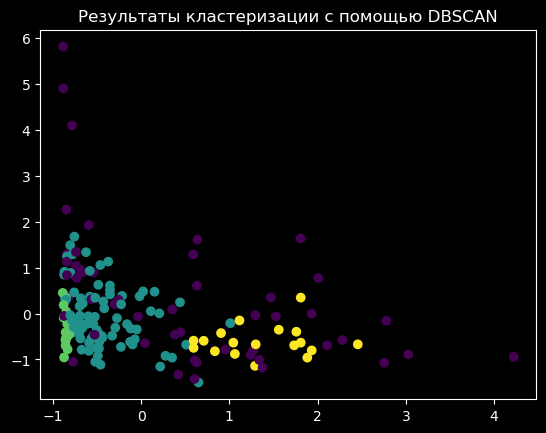

In [36]:
eps = 1.4
min_samples = 10

%time labels = dbscan(country_sdf, eps, min_samples)

plt.scatter(country_sdf[:, 0], country_sdf[:, 1], c=labels, cmap="viridis")
plt.title("Результаты кластеризации с помощью DBSCAN")
plt.savefig('../assets/country_own_dbscan.png')
plt.show()

CPU times: user 10 µs, sys: 7 µs, total: 17 µs
Wall time: 19.3 µs
CPU times: user 2.09 ms, sys: 356 µs, total: 2.45 ms
Wall time: 1.67 ms


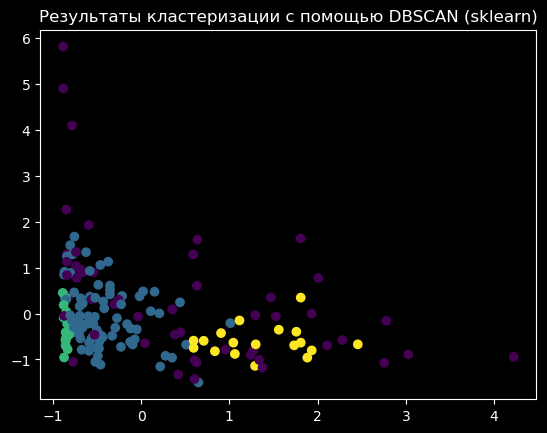

In [37]:
%time db = DBSCAN_sk(eps=1.4, min_samples=10)
%time labels_sk = db.fit_predict(country_sdf)

plt.scatter(country_sdf[:, 0], country_sdf[:, 1], c=labels_sk, cmap="viridis")
plt.title("Результаты кластеризации с помощью DBSCAN (sklearn)")
plt.savefig('../assets/country_bsbscam.png')
plt.show()

In [38]:
avg_intra, avg_inter = compute_metrics_dbscan(country_sdf, labels)
print(f"Среднее внутрикластерное расстояние (DBSCAN): {avg_intra}")
print(f"Среднее межкластерное расстояние (DBSCAN): {avg_inter}")

Среднее внутрикластерное расстояние (DBSCAN): 1.1735788904979276
Среднее межкластерное расстояние (DBSCAN): 2.0113982644880966
